# Module

In [1]:
from pylab import imshow
import numpy as np
import cv2
import torch
import albumentations as albu
import os
import sys
from glob import glob
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from time import time
from enum import Enum
import pandas as pd

import torch.utils.data as data

import matplotlib.pyplot as plt
import seaborn as sns

# Dataset

train이랑 eval folder를 기존 것을 사용하지 말고 새로 하나 복사해주세요.

그리고 복사된 folder를 경로로 지정하세요

In [2]:
# train.csv path 
df = pd.read_csv('/data/ephemeral/home/seg_data/train/train.csv')
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [3]:
data_path = '/data/ephemeral/home/seg_data/train/images/'  # Image path
data_list = sorted(glob(data_path + '*'))
data_list[:5]

['/data/ephemeral/home/seg_data/train/images/000001_female_Asian_45',
 '/data/ephemeral/home/seg_data/train/images/000002_female_Asian_52',
 '/data/ephemeral/home/seg_data/train/images/000004_male_Asian_54',
 '/data/ephemeral/home/seg_data/train/images/000005_female_Asian_58',
 '/data/ephemeral/home/seg_data/train/images/000006_female_Asian_59']

In [6]:
imgs = sorted(glob(data_list[0]+'/*'))
imgs

['/data/ephemeral/home/seg_data/train/images/000001_female_Asian_45/incorrect_mask.jpg',
 '/data/ephemeral/home/seg_data/train/images/000001_female_Asian_45/mask1.jpg',
 '/data/ephemeral/home/seg_data/train/images/000001_female_Asian_45/mask2.jpg',
 '/data/ephemeral/home/seg_data/train/images/000001_female_Asian_45/mask3.jpg',
 '/data/ephemeral/home/seg_data/train/images/000001_female_Asian_45/mask4.jpg',
 '/data/ephemeral/home/seg_data/train/images/000001_female_Asian_45/mask5.jpg',
 '/data/ephemeral/home/seg_data/train/images/000001_female_Asian_45/normal.jpg']

# 분할

In [7]:
!pip install iglovikov_helper_functions

In [8]:
from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image

In [14]:
!pip install people_segmentation  > /dev/null

In [9]:
from people_segmentation.pre_trained_models import create_model

/opt/conda/envs/mask/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 모형

In [10]:
# 사전학습된 U-Net 불러오기
model = create_model("Unet_2020-07-20")

/opt/conda/envs/mask/lib/python3.10/site-packages/torch/hub.py:682: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


In [11]:
# 장치 설정
device = torch.device('cuda')
model.to(device)
model.eval()

Unet(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Swish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNormAct2d(
            40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Swish()
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False

In [12]:
img_path = df.path
img_path[:5]

0    000001_female_Asian_45
1    000002_female_Asian_52
2      000004_male_Asian_54
3    000005_female_Asian_58
4    000006_female_Asian_59
Name: path, dtype: object

In [13]:
for path in tqdm(img_path):

    imgs = sorted(glob(data_path + path + '/*'))

    for img in imgs: 
        load_img = load_rgb(img)
        transform = albu.Compose([albu.Normalize(p=1)], p=1)
        padded_image, pads = pad(load_img, factor=32, border=cv2.BORDER_CONSTANT)
        X = transform(image=padded_image)["image"]
        X = torch.unsqueeze(tensor_from_rgb_image(X), 0)

        with torch.no_grad():
            prediction = model(X.to(device))[0][0]

        mask = (prediction > 0).cpu().numpy().astype(np.uint8)
        mask = unpad(mask, pads)

        final = load_img.copy()
        for i in range(3):
            final[:,:,i] = mask *load_img[:,:,i]

        final_img = Image.fromarray(final)
        final_img.save(img)


100%|██████████| 2700/2700 [09:09<00:00,  4.91it/s]


In [15]:
original = Image.open('/data/ephemeral/home/mask_data/train/images/000001_female_Asian_45/incorrect_mask.jpg')
original_arr = np.array(original)
seg = Image.open('/data/ephemeral/home/seg_data/train/images/000001_female_Asian_45/incorrect_mask.jpg')
seg_arr = np.array(seg)

(-0.5, 383.5, 511.5, -0.5)

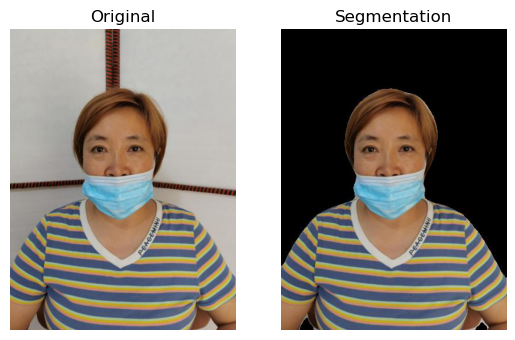

In [16]:
plt.figure()
plt.subplot(121)
plt.imshow(original_arr)
plt.title('Original')
plt.axis('off')

plt.subplot(122)
plt.imshow(seg_arr)
plt.title('Segmentation')
plt.axis('off')